# Importing data from Digital Globe

This Jupyter Notebook show a "pipeline" to retrieve DigitalGlobe imagery of the Torres Strait. To outcomes come from this Notebook. First, it shows how spatialy distributed are the images over the selected zone. Second, it create a visualization tool to capture the more frequent days of collection.


In [1]:
import gbdxtools
import numpy as np
#import geopandas as gpd
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import mapping, shape
import shapely as sp
from gbdx_auth import gbdx_auth
import geojson
%matplotlib inline

#Open a session using the Authentication files (~/.gbdx-config)
gbdx = gbdx_auth.get_session()
gbdx = gbdxtools.Interface()

In [2]:
from pprint import pprint
import json

#Create a area to search and retrieve information
wkt_string = "POLYGON((141.0205078125 -9.166331387642987, 143.602294921875 -9.155485188844034, 143.67919921875 -11.112885070321443, 140.965576171875 -11.11288507032144))"
filters = ["cloudCover < 30"]
#filters = ["sensorPlatformName = 'RADARSAT-2'"]
types = ['DigitalGlobeAcquisition']

results = gbdx.catalog.search(searchAreaWkt=wkt_string, 
                             startDate="2017-01-01T00:00:00.000Z", 
                              endDate="2017-06-19T00:00:00.000Z",
                             filters=filters,
                             types = types)

In [3]:
#Results is a json object (which is already a list, so no need of json.loads). First we can try with the first
#element of the json list.
a = results[1]['properties']['footprintWkt']
a_sp = sp.wkt.loads(a)

#If you want to take a look on what the GBDX search function returns you can print:
#pprint(results[1])

#We have retrieve this number of images
print("We have "+ str(len(results)) + " images available in the selected area!")

#Now that we have this, we can explore the spatial distribution of the images
tiles = []
for tile in results:
    tiles.append(tile['properties']['footprintWkt'])


We have 159 images available in the selected area!


#Graph Torres Strait
t_strait = Polygon([(141.0205078125, -9.166331387642987), (143.602294921875, -9.155485188844034), (143.67919921875, -11.112885070321443), (140.965576171875, -11.11288507032144)])
x,y = t_strait.exterior.xy

#Print coordinates of the TS to feed the basemap
print(t_strait.centroid.xy)

fig = plt.figure(1, figsize=(10,10), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='red', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
ax.set_title('Torres Strait') 

#Add tiles to the Torres Strait
for tile in tiles: 
    spatial_wkt = sp.wkt.loads(tile)
    for poly in spatial_wkt:
        x,y = poly.exterior.xy
        fig = plt.figure(1, figsize=(5,5), dpi=90)
        ax = fig.add_subplot(111)
        ax.plot(x, y, color='#6699cc', alpha=0.5, linewidth=1, solid_capstyle='round', zorder=2)



In [4]:
#Interactive plot with available imagery
from geomet import wkt
import pandas as pd
from pandas.io.json import json_normalize
import folium

#Create an interactive Leaflet map with the location of the torres strait
torres_strait = folium.Map(location = [-10.144989750644969, 142.3181966067051,], 
                           tiles='OpenStreetMap', 
                           zoom_start=6
                          )

#Option 1: Only plot the available images with the same color
tiles_geojson = []
for img in results:
    tiles_geojson.append(wkt.loads(img['properties']['footprintWkt']))
    for tile in tiles_geojson:
        tile["properties"] = img["properties"]
        
        
style_function = lambda x: {'borderColor': 'rgba(255, 0, 0, 0)'}

for tile in tiles_geojson:
    folium.GeoJson(tile, style_function=style_function).add_to(torres_strait)
        
#Option 2: Create a pd DataFrame to make a cloropeth by month
df_imgs = list(map(lambda x: x["properties"], results))
data_imgs = pd.read_json(json.dumps(df_imgs))

#If you want to explore the data dataframe you can print:
#print(data_imgs)




In [5]:
torres_strait

In [40]:
#Explore time of the images
data_imgs["timestamp"] = pd.to_datetime(data_imgs["timestamp"])
print(data_imgs["timestamp"])
data_imgs["date"] = pd.DatetimeIndex(data_imgs["timestamp"]).normalize() #This is not needed, is only to learn how to remove time from timestamps
data_imgs["day"], data_imgs["month"] = data_imgs["timestamp"].dt.day, data_imgs["timestamp"].dt.month

data_imgs_agg = pd.DataFrame(data_imgs.groupby(["date"]).size().rename("counts"))
data_imgs_agg["date"] = data_imgs_agg.index
data_imgs_agg["day"], data_imgs_agg["month"] = data_imgs_agg["date"].dt.day, data_imgs_agg["date"].dt.month

data_imgs_piv = data_imgs_agg.pivot(index='day', columns='month', values='counts')
data_imgs_piv = data_imgs_piv.fillna(0)
#print(data_imgs_piv)

0     2017-05-09 04:04:42.000
1     2017-05-09 04:04:52.000
2     2017-06-04 03:53:18.000
3     2017-06-04 00:53:18.000
4     2017-06-07 01:11:54.000
5     2017-06-07 01:12:09.000
6     2017-06-07 01:12:49.000
7     2017-06-07 01:11:37.000
8     2017-01-28 01:17:18.814
9     2017-02-10 01:02:11.583
10    2017-01-02 03:45:29.513
11    2017-01-16 01:23:47.545
12    2017-01-19 00:58:31.285
13    2017-01-10 03:56:58.693
14    2017-03-02 04:01:55.239
15    2017-04-13 01:26:49.686
16    2017-04-13 01:26:38.959
17    2017-04-18 01:07:40.000
18    2017-04-18 01:08:06.000
19    2017-03-18 01:07:32.231
20    2017-03-18 01:08:30.731
21    2017-05-01 01:17:13.000
22    2017-05-05 03:58:14.000
23    2017-06-01 01:16:00.000
24    2017-06-01 01:15:44.000
25    2017-05-31 03:47:44.000
26    2017-06-07 01:12:49.000
27    2017-06-07 01:11:37.000
28    2017-01-16 01:22:24.878
29    2017-01-14 00:59:47.643
                ...          
129   2017-05-20 01:22:27.000
130   2017-06-07 01:12:08.000
131   2017

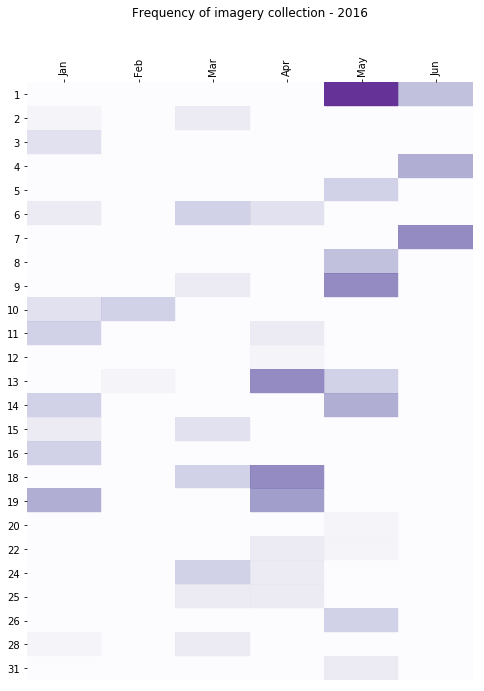

In [38]:
#Method taken from: http://nbviewer.jupyter.org/gist/joelotz/5427209 based on FlowingData Graph. 

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(data_imgs_piv, cmap=plt.cm.Purples, alpha=0.8)


##################################################
## FORMAT ##
##################################################

fig = plt.gcf()
fig.set_size_inches(8,11)

# turn off the frame
ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(data_imgs_piv.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data_imgs_piv.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# Set the labels

# label source:https://en.wikipedia.org/wiki/Basketball_statistics
labels = ['Jan', "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(labels, minor=False) 
ax.set_yticklabels(data_imgs_piv.index, minor=False)

# rotate the 
plt.xticks(rotation=90)

ax.grid(False)

# Turn off all the ticks
ax = plt.gca()
ax.set_title('Frequency of imagery collection - 2016\n\n\n\n') 



#for t in ax.xaxis.get_major_ticks(): 
#    t.tick1On = False 
#    t.tick2On = False 
#for t in ax.yaxis.get_major_ticks(): 
#    t.tick1On = False 
#    t.tick2On = False


In [39]:
#Export imagery metadata to check if coincides with AIS/SPIRE data
data_imgs.to_csv(path_or_buf="/mnt/data/shared/imgs_metadata_2017.csv")
